# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : 모델링 ver2 (확장)

할거 : 21,22(2개년도)년도 LSTM 모델링

### 0. 라이브러리 및 데이터 불러오기

라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LSTM, GRU, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

폰트 지정

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기(21 to 22 2개년도 데이터)

In [3]:
RANDOM_STATE = 110

data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_21to22.shape)

(27603, 90)


타겟비율 시각화

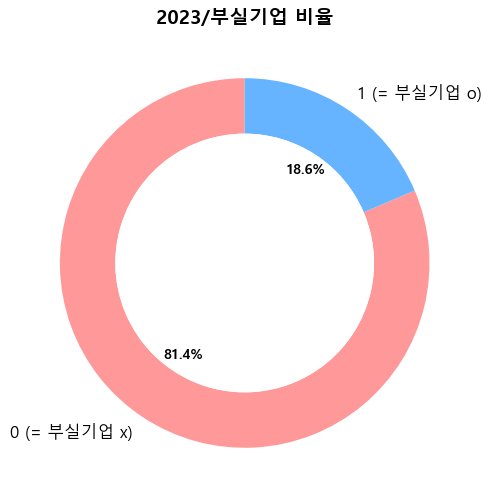

In [4]:
# '2023/부실기업' 비율 계산
value_counts = data_21to22['2023/부실기업'].value_counts()
labels = ['1 (= 부실기업 o)' if label == 1 else '0 (= 부실기업 x)' for label in value_counts.index]
sizes = value_counts.values

# 색상 설정
colors = ['#ff9999','#66b3ff']

# 도넛 차트 시각화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

# 도넛 차트의 가운데에 텍스트 추가
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 텍스트 스타일 설정
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=12)

# 차트 제목 추가
plt.title('2023/부실기업 비율', fontsize=14, weight='bold')

# 차트 표시
plt.show()

데이터 불균형 -> 평가지표로 accuracy(정확도)가 아닌 F1-score를 기준으로 한다.

### 1. 데이터 추가 전처리

In [5]:
# 종속 변수 설정
y = data_21to22['2023/부실기업']

# 연도별 특성 분리
X_2021 = data_21to22.filter(like='2021')  # 2021년 데이터
X_2022 = data_21to22.filter(like='2022')  # 2022년 데이터

# 재무비율 추출 함수
def extract_ratio_columns(df, year):
    return df.columns.str.replace(f'{year}/', '')

# 2021년과 2022년의 재무비율 추출
ratios_2021 = extract_ratio_columns(X_2021, '2021')
ratios_2022 = extract_ratio_columns(X_2022, '2022')

# 공통 재무비율 찾기
common_ratios = ratios_2021.intersection(ratios_2022)

# 공통 재무비율을 포함하는 변수명 생성
common_columns_2021 = [f'2021/{ratio}' for ratio in common_ratios]
common_columns_2022 = [f'2022/{ratio}' for ratio in common_ratios]

# 공통 변수만 사용하여 데이터 결합
X_2021_common = X_2021[common_columns_2021]
X_2022_common = X_2022[common_columns_2022]

# 전체 특성 결합 (타임 스텝을 위해 배열로 변환)
X_common = pd.concat([X_2021_common, X_2022_common], axis=1)

# 데이터 분할 (70:30 비율)
X_common_train, X_common_test, y_train, y_test = train_test_split(X_common, y, test_size=0.3, random_state=RANDOM_STATE)

# 데이터 정규화
scaler_common = StandardScaler()
X_common_train_scaled = scaler_common.fit_transform(X_common_train)
X_common_test_scaled = scaler_common.transform(X_common_test)

# 변수명을 유지하기 위해 DataFrame으로 변환
X_common_train_scaled_df = pd.DataFrame(X_common_train_scaled, columns=X_common_train.columns)
X_common_test_scaled_df = pd.DataFrame(X_common_test_scaled, columns=X_common_test.columns)

# 타임 스텝 설정
timesteps = 2  # 2021년과 2022년으로 2개의 타임 스텝으로 설정  # (샘플 수, 타임 스텝, 특성 수)
X_train_lstm = X_common_train_scaled_df.values.reshape((X_common_train_scaled_df.shape[0], timesteps, -1)) 
X_test_lstm = X_common_test_scaled_df.values.reshape((X_common_test_scaled_df.shape[0], timesteps, -1))

In [6]:
# 타임 스텝 확인
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

# 첫 번째 샘플의 타임 스텝별 데이터 확인
print("첫 번째 샘플의 첫 번째 타임 스텝 데이터:", X_train_lstm[0, 0, :])
print("첫 번째 샘플의 두 번째 타임 스텝 데이터:", X_train_lstm[0, 1, :])

X_train_lstm shape: (19322, 2, 21)
X_test_lstm shape: (8281, 2, 21)
첫 번째 샘플의 첫 번째 타임 스텝 데이터: [ 0.03807207 -0.0020328   0.05400356  0.05899398  0.07017119  0.14827777
  0.00180214  0.61243826 -0.33427654 -0.185362   -0.19290163 -0.19358192
 -0.03935053 -0.35014204  0.41301943  0.25458916  0.33200608 -0.04324597
 -0.03086146 -0.12714346 -0.22720773]
첫 번째 샘플의 두 번째 타임 스텝 데이터: [-0.54167093 -0.62132018 -0.51073733 -0.55508638 -0.57985577  0.097176
 -0.0018005  -0.13981697 -0.35060469 -0.18735672 -0.19095395 -0.19360187
 -0.06447123 -0.34301056  0.35340432  0.24664365  0.25629906 -0.07094113
 -0.02741867 -0.12251024 -0.21648227]


In [7]:
common_ratios

Index(['총자본영업이익율', '기업법인세비용차감전순이익율', '경영자본영업이익율', '자본금법인세비용차감전순이익율', '자본금순이익율',
       '매출액법인세비용차감전순이익율', '조세/조세차감전순이익비율', '차입금평균이자율', '금융비용/총비용비율',
       '영업이익이자보상비율', '법인세차감전순이익이자보상비율', 'EBITDA대금융비용', '현금비율', '유동부채비율',
       '순운전자본/총자본비율', '사내유보율', '유보액/총자산비율', '순이익(종업원1인당)', '법인세차감전순이익(구성비)',
       '금융비용(구성비)', '임차료(구성비)'],
      dtype='object')

---

### 2. 모델링

조기종료 코드 지우고 10 epoch으로 고정

In [8]:
# 모델 구축
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# 모델 예측
predictions_proba = model.predict(X_test_lstm)
predictions = (predictions_proba > 0.5).astype(int)

# 모델 평가
accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)[1]
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 1/10
604/604 [==============================] - 4s 3ms/step - loss: 0.2536 - accuracy: 0.8969
Epoch 2/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1735 - accuracy: 0.9257
Epoch 3/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1567 - accuracy: 0.9328
Epoch 4/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1480 - accuracy: 0.9368
Epoch 5/10
604/604 [==============================] - 2s 4ms/step - loss: 0.1424 - accuracy: 0.9391
Epoch 6/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1371 - accuracy: 0.9404
Epoch 7/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1351 - accuracy: 0.9414
Epoch 8/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1315 - accuracy: 0.9433
Epoch 9/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1290 - accuracy: 0.9442
Epoch 10/10
259/259 [==============================] - 1s 1ms/step
Accuracy: 0.9327, F1 Score: 0.827

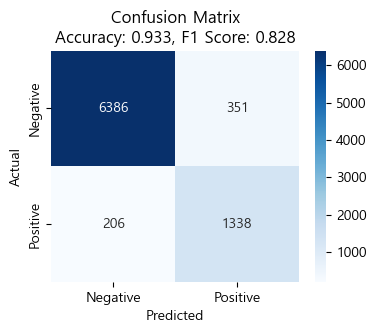

<Figure size 640x480 with 0 Axes>

In [9]:
# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}, F1 Score: {f1:.3f}')
plt.show()

# 정확도와 F1 점수 출력
plt.figtext(0.5, -0.1, f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}', ha='center', va='center', fontsize=12)
plt.show()

# 모델 저장
model.save('lstm_model.h5')

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

def evaluate_model(predictions_proba, threshold, X_test, y_test, model):
    predictions = (predictions_proba > threshold).astype(int)
    
    # 모델 평가
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    # 혼동 행렬 출력
    conf_matrix = confusion_matrix(y_test, predictions)
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')
    plt.show()
    
    # 정확도, 정밀도, 재현율, F1 점수 출력
    plt.figtext(0.5, -0.1, f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}', ha='center', va='center', fontsize=12)
    plt.show()

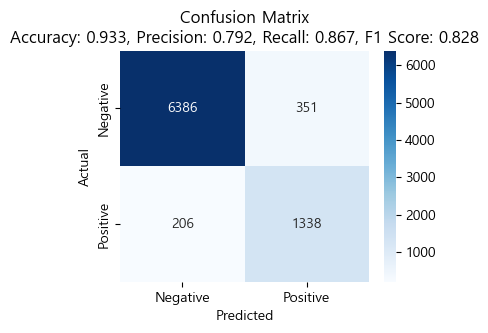

<Figure size 640x480 with 0 Axes>

In [35]:
evaluate_model(predictions_proba, 0.5, X_test_lstm, y_test, model)

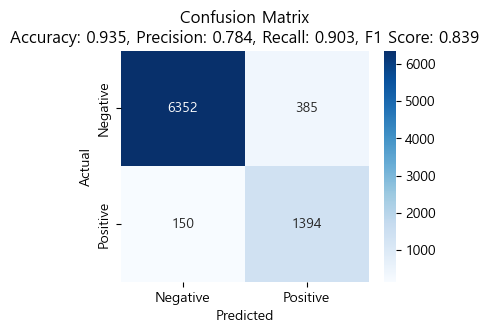

<Figure size 640x480 with 0 Axes>

In [36]:
evaluate_model(predictions_proba, 0.4, X_test_lstm, y_test, model)

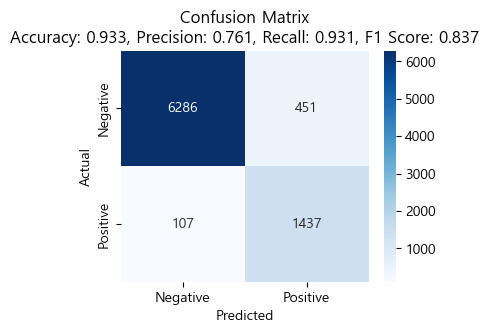

<Figure size 640x480 with 0 Axes>

In [39]:
evaluate_model(predictions_proba, 0.3, X_test_lstm, y_test, model)

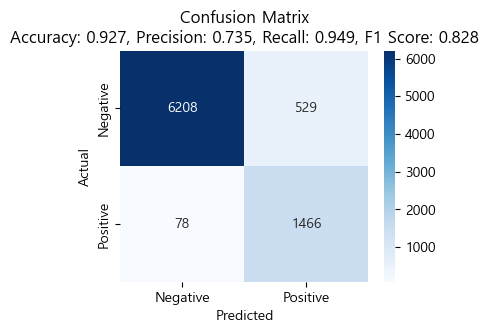

<Figure size 640x480 with 0 Axes>

In [40]:
evaluate_model(predictions_proba, 0.2, X_test_lstm, y_test, model)

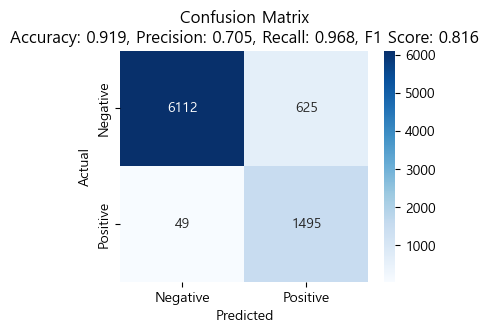

<Figure size 640x480 with 0 Axes>

In [44]:
evaluate_model(predictions_proba, 0.12, X_test_lstm, y_test, model)

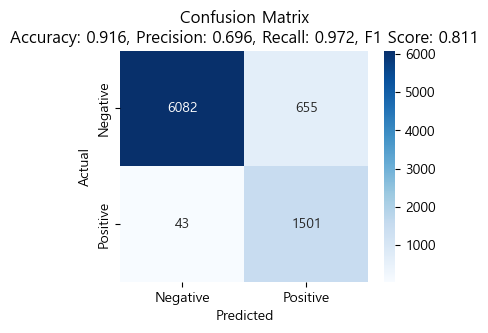

<Figure size 640x480 with 0 Axes>

In [41]:
evaluate_model(predictions_proba, 0.1, X_test_lstm, y_test, model)

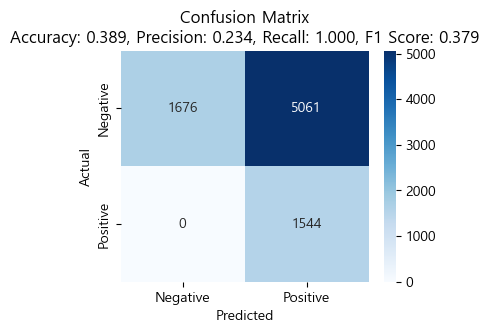

<Figure size 640x480 with 0 Axes>

In [42]:
evaluate_model(predictions_proba, 0, X_test_lstm, y_test, model)

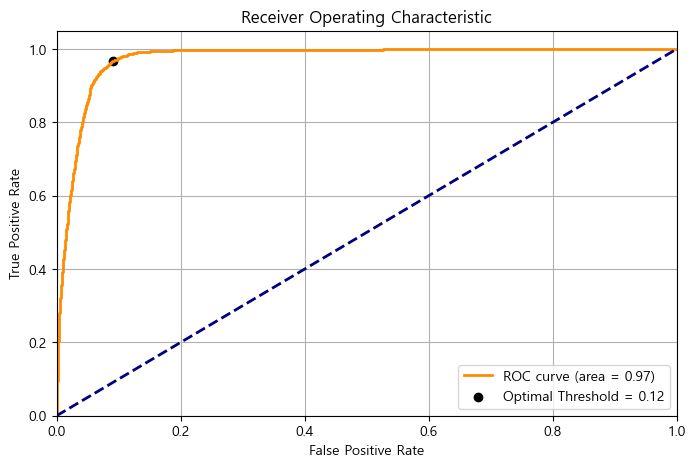

Optimal Threshold: 0.12


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def find_optimal_threshold(predictions_proba, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)
    roc_auc = auc(fpr, tpr)
    
    # Youden's J statistic to find the optimal threshold
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return optimal_threshold

# 함수 사용 예시
optimal_threshold = find_optimal_threshold(predictions_proba, y_test)
print(f'Optimal Threshold: {optimal_threshold:.2f}')

| 지표                          | 의미                                    | 계산식                         |
|-------------------------------|----------------------------------------|--------------------------------|
| TPR (True Positive Rate)      | 실제 양성 중에서 올바르게 예측한 비율    | (\frac{TP}{TP + FN})           | 
| FPR (False Positive Rate)     | 실제 음성 중에서 잘못 예측한 비율        | (\frac{FP}{FP + TN})           | 

TPR - FPR 의 값이 최대가 되는 Threhold를 최적의 스레스홀드로 선정

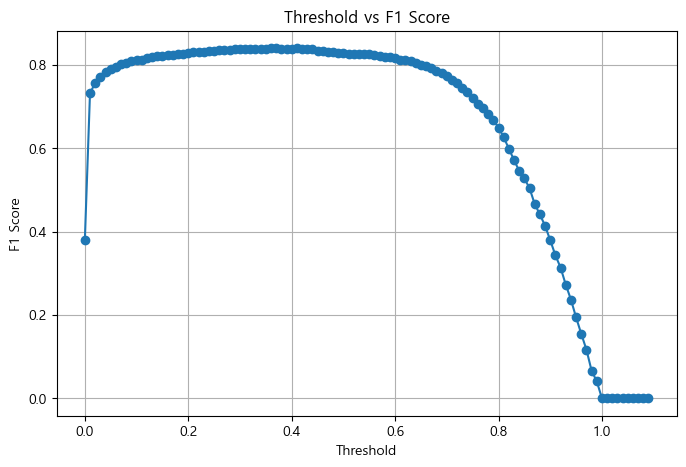

Optimal Threshold: 0.37, Max F1 Score: 0.8399


In [45]:
import numpy as np
from sklearn.metrics import f1_score

def find_optimal_threshold_for_f1(predictions_proba, y_test):
    thresholds = np.arange(0.0, 1.1, 0.01)
    f1_scores = []

    for threshold in thresholds:
        predictions = (predictions_proba > threshold).astype(int)
        f1 = f1_score(y_test, predictions)
        f1_scores.append(f1)

    optimal_threshold = thresholds[np.argmax(f1_scores)]
    max_f1_score = max(f1_scores)

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold vs F1 Score')
    plt.grid(True)
    plt.show()

    return optimal_threshold, max_f1_score

# 함수 사용 예시
optimal_threshold, max_f1_score = find_optimal_threshold_for_f1(predictions_proba, y_test)
print(f'Optimal Threshold: {optimal_threshold:.2f}, Max F1 Score: {max_f1_score:.4f}')

.